# Bayesian Analysis Demo for Beth

Ariel Zeleznikow-Johnston  
10-Feb-2022

In [3]:
# libraries
shhh <- suppressPackageStartupMessages # stops annoying warnings when loading libraries
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [85]:
# bayesian analysis libraries
library(bayesbr)
library(BayesFactor)
#library(brms)
library(rstanarm)
library(bridgesampling)
library(bayestestR)
#library(see)
#library(bayesplot)
library(betareg)

ERROR: Error in library(betareg): there is no package called 'betareg'


In [76]:
install.packages('logspline')

package 'logspline' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\Rtmpm2Xsfm\downloaded_packages


In [86]:
install.packages('betareg')

also installing the dependencies 'nnet', 'flexmix', 'modeltools'




package 'nnet' successfully unpacked and MD5 sums checked
package 'flexmix' successfully unpacked and MD5 sums checked
package 'modeltools' successfully unpacked and MD5 sums checked
package 'betareg' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\Rtmpm2Xsfm\downloaded_packages


In [4]:
# read the csv data files into a dataframe
files = list.files(pattern="*.csv")
data = sapply(files, read.csv, simplify=FALSE) %>% bind_rows(.id = "id")

In [5]:
# Select variables we need for analysis 
trial_vars<- c( "participant",
                "Colour_1", "Colour_2", "Colour1", "Colour2", 
                "similarity", "response_time",  "Ecc","screen_size_x",
                "screen_size_y","answer5",
                "viewerdistancecm", 'viewer_distance',"trialnumber","Ecc",'expName')

data <- subset(data, select = trial_vars)

In [6]:
# Create data frame for trials 
dftrials <- subset(data, !is.na(Colour1))

# Label participant number
dftrials$ID <- NA
subjectlist <- unique(dftrials$participant)
k= 0
for (participant in subjectlist){
  k = k + 1
  dftrials$ID[dftrials$participant == participant] <- k
}

In [7]:
# changing color values from RGB to hex for graphing purpose
dftrials$Colour1 <- as.character(dftrials$Colour1)
dftrials$Colour1 <- revalue(dftrials$Colour1, 
                            c(  "1" = '#FF0000',
                                "2" = '#FFAA00',
                                "3" = '#AAFF00',
                                "4" = '#00FF00',
                                "5" = '#00FFA9',
                                "6" = '#00A9FF',
                                "7" = '#0000FF',
                                "8" = '#AA00FF',
                                "9" = '#FF00AA'))
dftrials$Colour2 <- as.character(dftrials$Colour2)
dftrials$Colour2 <- revalue(dftrials$Colour2, 
                            c(  "1" = '#FF0000',
                                "2" = '#FFAA00',
                                "3" = '#AAFF00',
                                "4" = '#00FF00',
                                "5" = '#00FFA9',
                                "6" = '#00A9FF',
                                "7" = '#0000FF',
                                "8" = '#AA00FF',
                                "9" = '#FF00AA'))

# colors for the labels
# red, orange, yellow, green, cyan, cyan-blue, blue, purple, pink
colors <- c('#FF0000','#FFAA00','#AAFF00','#00FF00','#00FFA9','#00A9FF','#0000FF','#AA00FF','#FF00AA')
# can change the way the plot line up
# red, pink, orange, purple, yellow, blue, green, cyan-blue, cyan
#colors <- c('#FF0000','#FF00AA','#FFAA00','#AA00FF','#AAFF00','#0000FF','#00FF00','#00A9FF','#00FFA9')
abcolors <- sort(colors) # this was messing up the asymmetry plot, maybe useful for some other stuff

In [11]:
# factor the dataframes for the plot function
dissimdata2 <- function(dftrials, colors){
  
  # refactor the levels so they can be plotted properly later if need be
  dftrials$Colour1 <- with(dftrials, factor(Colour1, levels = colors))
  dftrials$Colour2 <- with(dftrials, factor(Colour2, levels = colors))
  
  return(dftrials)
}

In [8]:
df2mat_asymmetry_temporal <- function(dftrials){
  
  datatemp <- dissimdata2(dftrials, colors)
  
  # aggregate over the remaining columns of interest
  nmdsdata <- aggregate(datatemp, by = list(datatemp$Colour1, datatemp$Colour2),FUN=mean)
  nmdsdata$Colour1 <- nmdsdata$Group.1
  nmdsdata$Colour2 <- nmdsdata$Group.2
  
  nmdsdata = subset(nmdsdata, select = c("Colour1","Colour2","similarity"))  # get rid of unnecessary columns
  nmdsmatrix <- spread(nmdsdata, Colour1, similarity) # convert the dataframe to a matrix
  nmdsmatrix <- data.matrix(nmdsmatrix) # change first column from colour to number(just some label stuff) 
  nmdsmatrix <- nmdsmatrix[,-1] # get rid of the labels in the first column, it messes up the code
  
  matdf<-  as.data.frame(nmdsmatrix - t(nmdsmatrix)) # calculate the asymmetry
  matdf$colorset <- c(colors) # adding additional column "colorset"
  num_colors <- length(colors)
  matdf <- matdf %>% gather(othercolor,asymmetry ,1:num_colors) # convert the matrix back to the data frame which has the 
  # column "colortset", "othercolor", "asymmetry"
  return(matdf)
}

In [9]:
# Convert dataframe into a list of asymmtery matrix for each subject
dissimgroup2matlist <- function(dftrials){
  subjectlist <- sort(unique(dftrials$ID)) # obtain a list of all the subjects
  mat.list <- list()
  k = 1
  for(ID in subjectlist){
    subjectdf <- dftrials[which(dftrials$ID==ID),]
    subject.mat <- df2mat_asymmetry_temporal(subjectdf)
    mat.list[[k]] <- subject.mat
    k = k + 1
  }
  return(mat.list)
}

In [ ]:
mat.list <- dissimgroup2matlist(dftrials)


Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(X[[i]], ...):
"argument is not numeric or logical: returning NA"
Warning message in mean.defaul

In [16]:
# Return a list of asymmtery values for each cell 
vals.list.fun <- function(mat.list){
  n.cells <- 81
  n.subjects <- length(mat.list)
  
  k=1
  vals.list <- list()
  
  for(cell in 1:n.cells){
    v <- vector()
    for(subject in 1:n.subjects){
      v <- c(v,mat.list[[subject]][[3]][cell])
    }
    vals.list[[cell]] <- v
  }
  return(vals.list)   
}

In [17]:
vals.list <-vals.list.fun(mat.list)


In [30]:
length(vals.list[[1]])

[1] 40

### Data visualisations

In [32]:
# collect all the asymmetry values into one vector. Not sure if this is the correct unit of analysis
# but it let me make the demo easily
all.vals <- vector()
for(i in 1:length(vals.list)){
    all.vals <- c(all.vals,vals.list[[i]])
} 
#40*81
#length(all.vals)

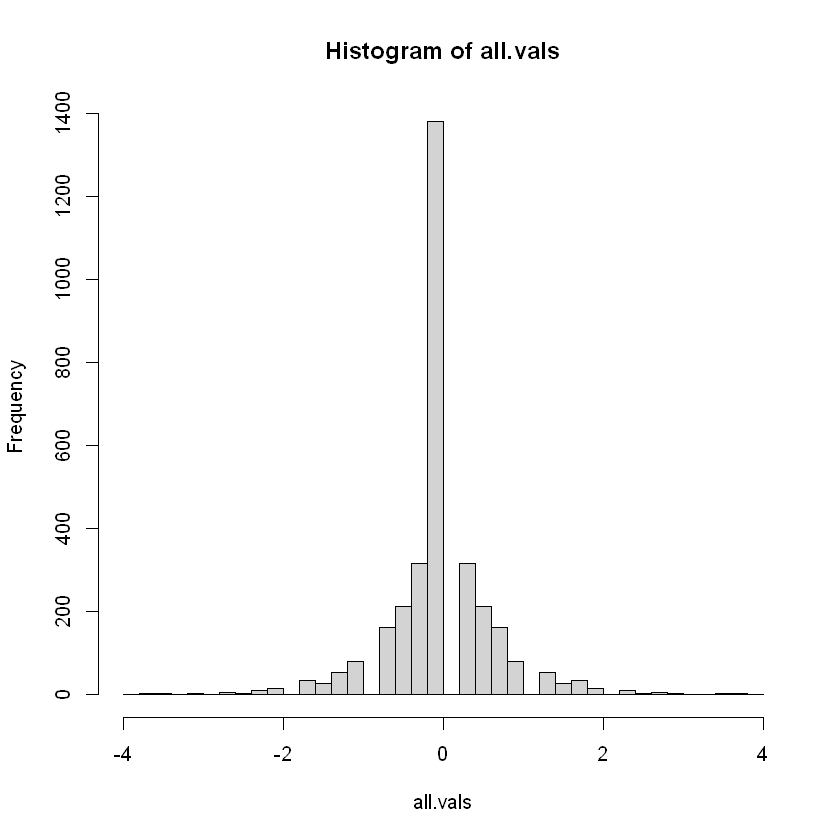

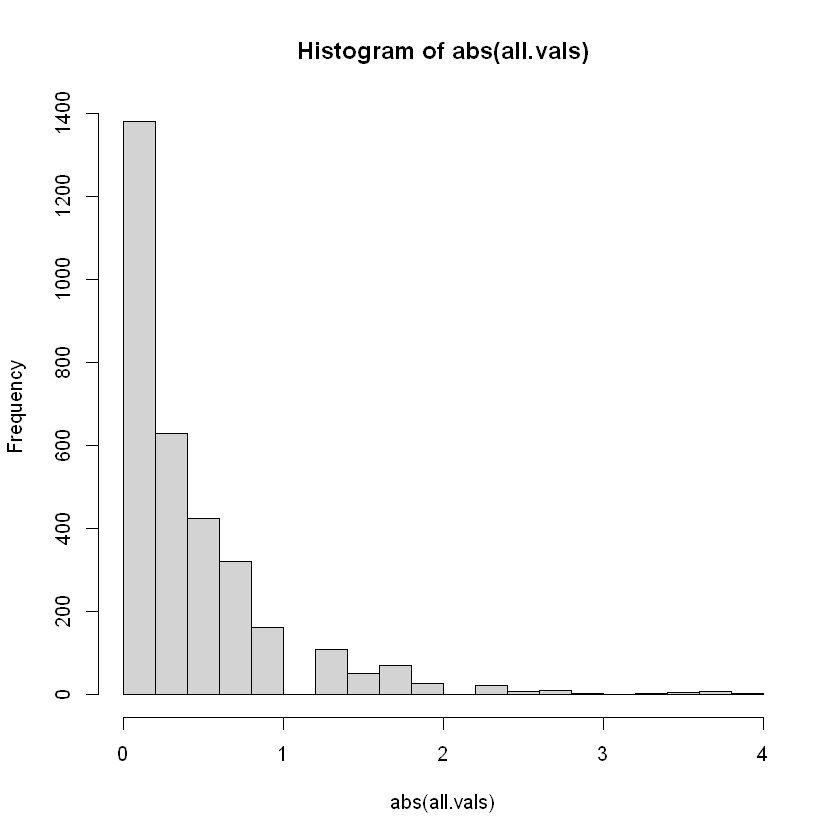

In [42]:
hist(all.vals,breaks=8*2*2)
hist(abs(all.vals),breaks=8*2)

In [92]:
# function to perform boundary offsets for beta-distributed data
# suggested by http://doi.apa.org/getdoi.cfm?doi=10.1037/1082-989X.11.1.54
offset.beta <- function(vector){
    offset <- (vector * (length(vector)-1) + 0.5) / length(vector)
    return(offset/(max(offset)+0.1)) # the +0.1 is just to allow the betareg below to work, but it's not a proper fix
}

In [93]:
model.vals <- offset.beta(all.vals)
model.vals <- abs(model.vals)
all.vals.df <- as.data.frame(model.vals)

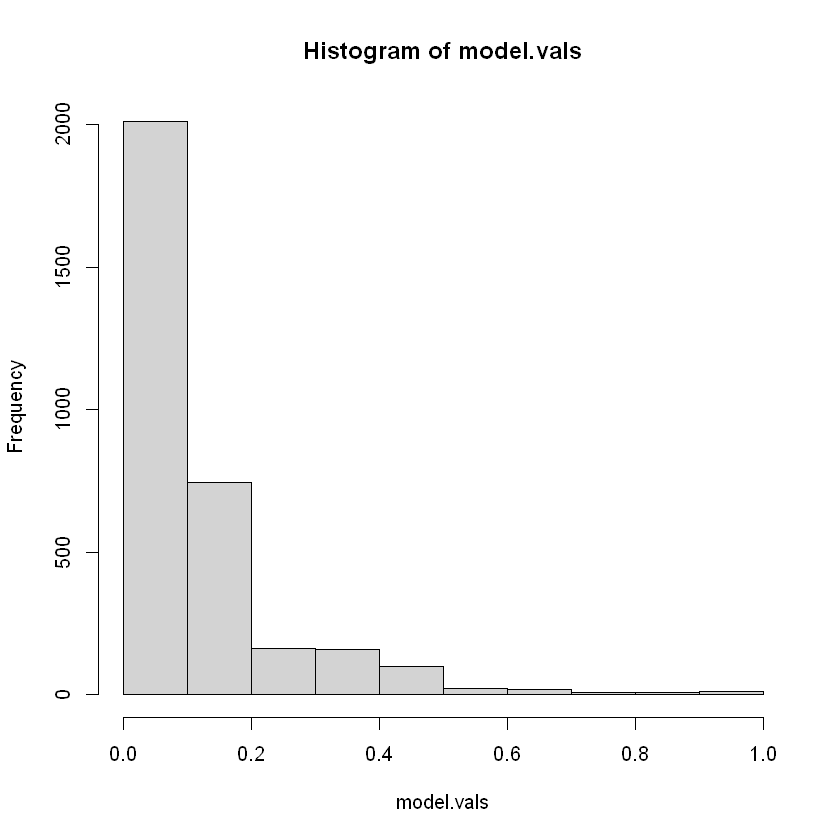

In [94]:
hist(model.vals)

In [81]:
# Testing whether the mean of the distribution is non-zero
h1.model.gamma <- stan_glm(
    formula = model.vals ~ 1,
    family = Gamma(link = 'identity'), # might need to specify the link?
    data = all.vals.df,
    refresh=0
                    )

In [82]:
print(summary(h1.model.gamma))


Model Info:
 function:     stan_glm
 family:       Gamma [identity]
 formula:      model.vals ~ 1
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 3240
 predictors:   1

Estimates:
              mean   sd   10%   50%   90%
(Intercept) 0.1    0.0  0.1   0.1   0.1  
shape       0.2    0.0  0.2   0.2   0.2  

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.1    0.0  0.1   0.1   0.1  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse Rhat n_eff
(Intercept)   0.0  1.0  2778 
shape         0.0  1.0  2198 
mean_PPD      0.0  1.0  3144 
log-posterior 0.0  1.0  1658 

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size, and Rhat is the potential scale reduction factor on split chains (at convergence Rhat=1).


                  2.5%     97.5%
(Intercept) 0.09656386 0.1118561
shape       0.21710536 0.2340369


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |       BF
----------------------
(Intercept) | 9.07e+26

* Evidence Against The Null: 0

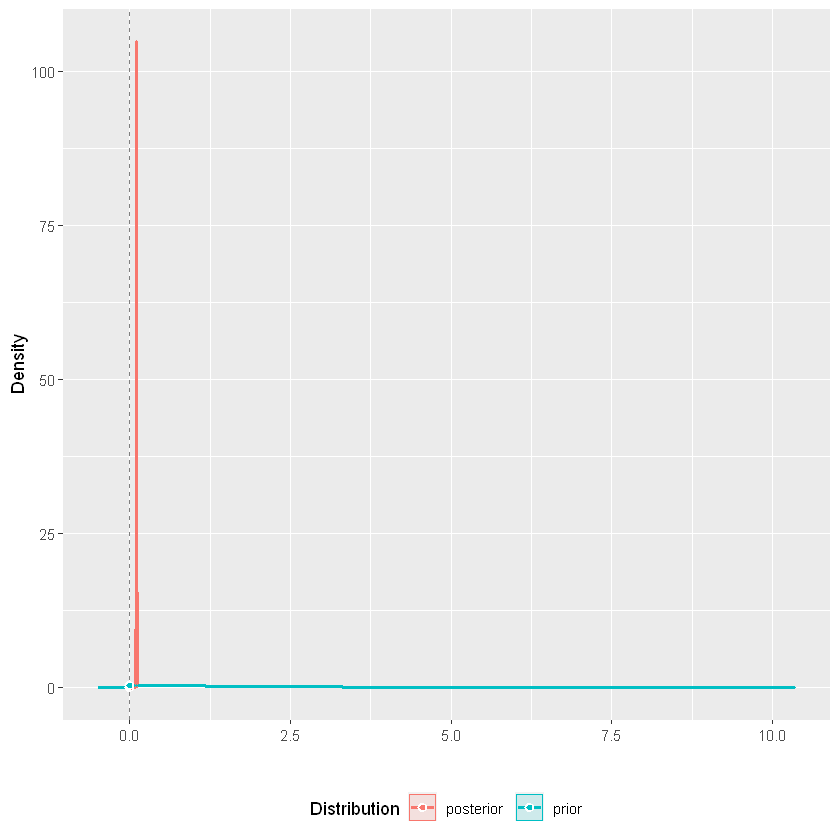

In [83]:
HPD <- posterior_interval(h1.model.gamma, prob = 0.95)
print(HPD)
BF <- bayesfactor_parameters(h1.model.gamma)
print(BF)
print(plot(BF, show_intercept=TRUE))

In [100]:
# Testing whether the mean of the distribution is non-zero
# using a beta distribution
h1.model.beta <- stan_betareg(
    formula = model.vals ~ 1,
    #link = 'identity', # might need to specify the link?
    data = all.vals.df,
    refresh=0
                    )

In [101]:
print(summary(h1.model.beta))


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      model.vals ~ 1
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 3240

Estimates:
              mean   sd   10%   50%   90%
(Intercept) -2.3    0.0 -2.3  -2.3  -2.2 
(phi)        2.3    0.1  2.2   2.3   2.4 

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 0.1    0.0  0.1   0.1   0.1  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse Rhat n_eff
(Intercept)   0.0  1.0   928 
(phi)         0.0  1.0   995 
mean_PPD      0.0  1.0  1436 
log-posterior 0.0  1.0  1035 

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size, and Rhat is the potential scale reduction factor on split chains (at convergence Rhat=1).


                 2.5%     97.5%
(Intercept) -2.320127 -2.188351
(phi)        2.118600  2.427877


Sampling priors, please wait...



Bayes Factor (Savage-Dickey density ratio) 

Parameter   |       BF
----------------------
(Intercept) | 2.89e+72

* Evidence Against The Null: 0

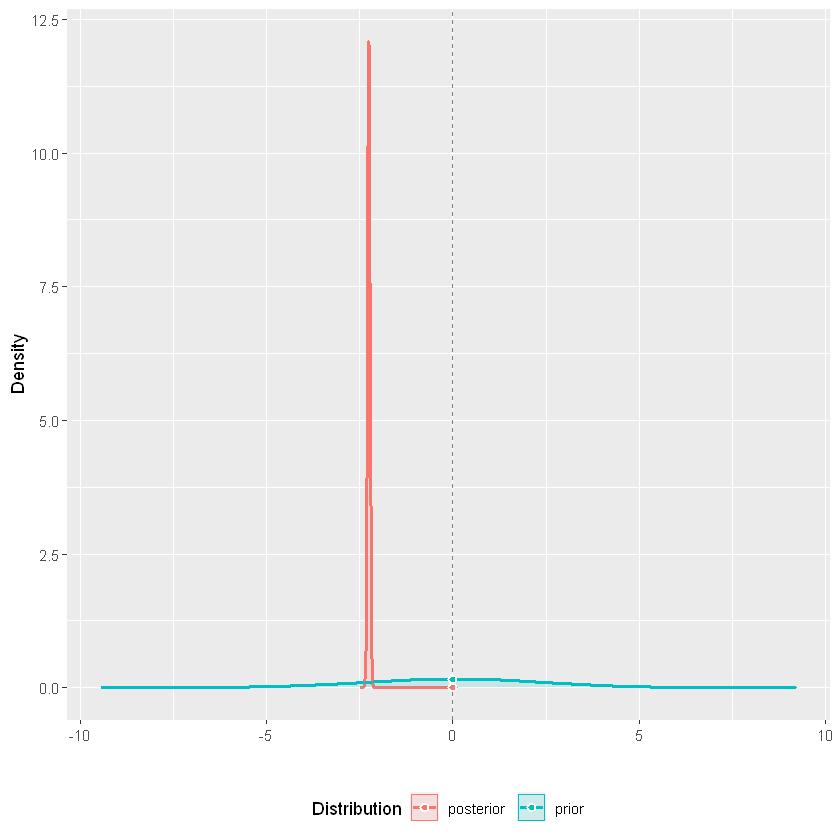

In [102]:
HPD <- posterior_interval(h1.model.beta, prob = 0.95)
print(HPD)
BF <- bayesfactor_parameters(h1.model.beta)
print(BF)
print(plot(BF, show_intercept=TRUE))